In [1]:
!which python; python --version; pwd

/Users/swagatam/miniconda3/envs/sbi/bin/python
Python 3.10.14
/Users/swagatam/Desktop/ws24/sbi/sourcerer-sequential/results_analysis


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [40]:
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2
# matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.family'] = "Times New Roman" # to match ICLR template
# matplotlib.rcParams['font.family'] = "Helvetica"
# matplotlib.rcParams['legend.fontsize'] = 15
# matplotlib.rcParams['axes.labelsize'] = 15
# matplotlib.rcParams['xtick.labelsize'] = 15
# matplotlib.rcParams['ytick.labelsize'] = 15
# matplotlib.rcParams['legend.title_fontsize'] = 15
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
# matplotlib.rcParams['figure.dpi'] = 250
# matplotlib.rcParams['figure.figsize'] = (4,3)
# cmap = plt.get_cmap("viridis")

this notebook has baseline and data aggregation results:
- with fixed lambda, no aggregation of training data over iterations
- if keeping data from previous iterations helps (aggregate data)

In [4]:
base_path_baseline = '../results_sequential_naive_baseline/'
base_path_aggregate = '../results_sequential_naive_aggrdata/'
foldertxt = "seq_{S}_{B}_{I}_{SEED}"
filetxt = 'run_{B}_{I}_{SEED}_results_df.csv'

In [188]:
SIMULATORS = ["gaussian_mixture", "inverse_kinematics", "two_moons", "slcp"]
SEEDS = {
    "gaussian_mixture": [34358, 12235, 9656, 3828, 54973],
    "inverse_kinematics": [34358, 12235, 9656, 3828, 54973],
    "two_moons": [50134, 12235, 9656, 3828, 54973],
    "slcp": [20367, 12235, 9656, 3828, 54973]
}
METRICS_NAMES = ['surro_c2sts',
                 'source_simu_pf_c2sts',
                 'source_surro_pf_c2sts',
                 "source_simu_pf_swds",
                 'source_entropies'
                ]
METRICS_LABELS = {
    "surro_c2sts": "Surrogate C2ST",
    "source_simu_pf_swds": "Source SWD (PF using sim.)",
    # "source_simu_pf_c2sts": "Source C2ST\n(PF using sim.)",
    "source_simu_pf_c2sts": "Source C2ST (PF using sim.)",
    "source_surro_pf_c2sts": "Source C2ST\n(PF using surr.)",
    "source_entropies": "Source entropy estimate",
}

In [6]:
np.genfromtxt('../results_sequential_naive_aggrdata/seq_slcp_12000_10_20367/run_12000_10_20367_expected_swd.csv')

array(0.17703132)

In [7]:
# mean_gt_swd(base_path_baseline, 'slcp', 1000, 4)

In [8]:
def path_to_csv(base_path, sim, budget, iters, seed):
    return os.path.join(base_path,
                        foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                        filetxt.format(B=budget, I=iters, SEED=seed)
                       )
def average_df_over_seeds(base_path, sim, budget, iters):
    dflist = []
    columns = pd.read_csv(path_to_csv(base_path, sim, budget, iters, SEEDS[sim][0])).columns # just fetch column names
    for seed in SEEDS[sim]:
        path = path_to_csv(base_path, sim, budget, iters, seed)
        if os.path.exists(path):
            dflist.append(
                pd.read_csv(path)
            )
        else:
            print(f"Could not find file: {path}")
    # assert len(dflist) == len(SEEDS[sim])
    mean_df = pd.DataFrame(np.stack(dflist, axis=0).mean(0), columns=columns)
    std_df = pd.DataFrame(np.stack(dflist, axis=0).std(0), columns=columns)
    return mean_df, std_df

def gt_source_kole(base_path, sim, budget, iters, seed):
    path_to_array = os.path.join(base_path,
                                 foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                 f"run_{budget}_{iters}_{seed}_gt_source_kole.csv"
                                )
    # print(path_to_array)
    return np.genfromtxt(path_to_array)

def mean_gt_source_kole(base_path, sim, budget, iters):
    arrays = []
    for seed in SEEDS[sim]:
        arrays.append(
            gt_source_kole(base_path, sim, budget, iters, seed)
        )
    # print(arrays)
    return np.array(arrays).mean()

def gt_swd(base_path, sim, budget, iters, seed):
    # print(sim, budget, iters, seed)
    path_to_array = os.path.join(base_path,
                                 foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                 f"run_{budget}_{iters}_{seed}_expected_swd.csv"
                                )
    # print(path_to_array)
    return np.genfromtxt(path_to_array)


def mean_gt_swd(base_path, sim, budget, iters):
    arrays = []
    for seed in SEEDS[sim]:
        arrays.append(
            gt_swd(base_path, sim, budget, iters, seed)
        )
    # print(arrays)
    return np.array(arrays).mean()


def fetch_losses(base_path, sim, budget, iters, seed):
    train_losses_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_train_losses_surro.csv"
                                    )
    val_losses_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_val_losses_surro.csv"
                                    )
    train_losses_source_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_source_training_losses.csv"
                                    )
    train_losses = np.genfromtxt(train_losses_path)
    val_losses = np.genfromtxt(val_losses_path)
    train_losses_source = np.genfromtxt(train_losses_source_path)
    
    return train_losses, val_losses, train_losses_source


def loss_plots(base_path, sim, budget, iters, seed, start_idx=100):
    train, val, src_train = fetch_losses(base_path, sim, budget, iters, seed)

    title = f"{sim}\nb={budget}, its={iters}"
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
    
    axes[0].plot(train[start_idx:], label=f"surro. train loss")
    axes[0].plot(val[start_idx:], label=f"surro. val. loss")
    axes[0].set_xlabel("epochs")
    axes[0].legend(fontsize=6, title=title, title_fontsize=7)
    axes[1].plot(src_train, label=f"source training loss"); 
    axes[1].set_xlabel("epochs")
    # axes[1].set_yscale('log')
    axes[1].legend(fontsize=6, title=title, title_fontsize=7)
    
    return fig

In [9]:
simulator = "inverse_kinematics"
b=15000
it=5
seed = SEEDS[simulator][0]
seed

34358

In [10]:
pd.read_csv(path_to_csv(base_path_aggregate, simulator, b, it, SEEDS[simulator][2]))

budgets  surro_c2sts  surro_swds  source_simu_pf_swds  \
0     3000      0.70315    0.200758             0.066134   
1     3000      0.52650    0.029427             0.022772   
2     3000      0.48065    0.008257             0.019189   
3     3000      0.47260    0.005962             0.022417   
4     3000      0.46835    0.006093             0.025086   

   source_simu_pf_c2sts  source_surro_pf_c2sts  source_c2sts  source_entropies  
0               0.65200                0.65540       0.92735          3.666640  
1               0.51245                0.52030       0.86440          3.784482  
2               0.49810                0.50415       0.85330          3.792611  
3               0.49790                0.50555       0.85420          3.851130  
4               0.49630                0.50635       0.85275          3.912458

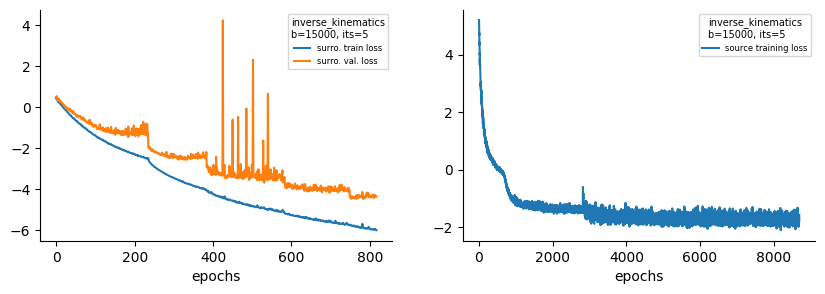

In [11]:
loss_plots(base_path_aggregate, simulator, b, it, SEEDS[simulator][2])
plt.show()

In [12]:
average_df_over_seeds(base_path_baseline, simulator, b, it)[0]

budgets  surro_c2sts  surro_swds  source_simu_pf_swds  \
0   3000.0      0.67862    0.188140             0.058417   
1   3000.0      0.53019    0.041986             0.026185   
2   3000.0      0.49363    0.024446             0.025288   
3   3000.0      0.48156    0.022841             0.026771   
4   3000.0      0.47566    0.018552             0.022347   

   source_simu_pf_c2sts  source_surro_pf_c2sts  source_c2sts  source_entropies  
0               0.63537                0.63105       0.92387          3.668719  
1               0.52725                0.53255       0.86949          3.772140  
2               0.50736                0.51019       0.85308          3.790085  
3               0.50943                0.51316       0.85032          3.822999  
4               0.50274                0.50700       0.85142          3.834508

In [13]:
average_df_over_seeds(base_path_aggregate, simulator, b, it)[0]

budgets  surro_c2sts  surro_swds  source_simu_pf_swds  \
0   3000.0      0.67862    0.188140             0.058417   
1   3000.0      0.53449    0.038335             0.028814   
2   3000.0      0.48860    0.011655             0.024780   
3   3000.0      0.47804    0.009067             0.026037   
4   3000.0      0.46934    0.008037             0.023565   

   source_simu_pf_c2sts  source_surro_pf_c2sts  source_c2sts  source_entropies  
0               0.63537                0.63105       0.92387          3.668719  
1               0.52606                0.53198       0.86806          3.750849  
2               0.50514                0.50604       0.85273          3.766548  
3               0.50335                0.50627       0.85218          3.819231  
4               0.50245                0.50632       0.85273          3.852311

In [14]:
average_df_over_seeds(base_path_aggregate, simulator, b, it)[1]

budgets  surro_c2sts  surro_swds  source_simu_pf_swds  \
0      0.0     0.066845    0.084086             0.019584   
1      0.0     0.024902    0.010998             0.007170   
2      0.0     0.006420    0.002658             0.007253   
3      0.0     0.003439    0.001831             0.003972   
4      0.0     0.004297    0.001537             0.002428   

   source_simu_pf_c2sts  source_surro_pf_c2sts  source_c2sts  source_entropies  
0              0.041288               0.050051      0.026305          0.040264  
1              0.013612               0.018114      0.011716          0.024692  
2              0.004406               0.004472      0.007386          0.059583  
3              0.003199               0.001768      0.005716          0.050924  
4              0.003728               0.004637      0.004609          0.059538

In [15]:
BUDGETS = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 12_000, 15_000]
ITERS = [1, 2, 3, 4, 5, 6, 8, 10]

In [16]:
def plot_metrics(simulator, base_path):
    rows, nrows = BUDGETS, len(BUDGETS)
    ncols = len(METRICS_NAMES)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4.5*nrows), gridspec_kw={'wspace':0.2,'hspace':0.5})

    gt_ent, gt_wasser = None, None
    for loci, b in enumerate(rows):
        gt_entropy = mean_gt_source_kole(base_path, simulator, b, 1)
        gt_wasser = mean_gt_swd(base_path, simulator, b, 1)
        
        vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
        stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
        for i, num_iters in enumerate(ITERS):
            mean_df, std_df = average_df_over_seeds(base_path, simulator, b, num_iters)
            mean_df = mean_df[METRICS_NAMES].iloc[-1:]
            std_df = std_df[METRICS_NAMES].iloc[-1:]
            vals[i], stds[i] = mean_df.values, std_df.values

        for locj in range(ncols):
            ax = axes[loci, locj]
            ax.errorbar(x=ITERS, y=vals[:, locj], yerr=stds[:, locj], capsize=1.5, elinewidth=2, fmt='o', linestyle='-')#, label="Direct DT")
            # ax.plot(iters, vals[:, locj], 'o-')
            if locj!=ncols-1:
                ax.set_ylim(0.45, 0.9)
                ax.axhline(0.5, color='g', ls=':')
            else:
                ax.axhline(gt_entropy, color='k', ls=':', label='gt kole')
                # ax.axhline(gt_swds, color='r', ls=':', label='gt swd')
                ax.legend()

            ax.set_title(f"{simulator}, B: {b}")
            ax.set_xlabel("# iterations")
            ax.set_ylabel(METRICS_NAMES[locj])

    return fig

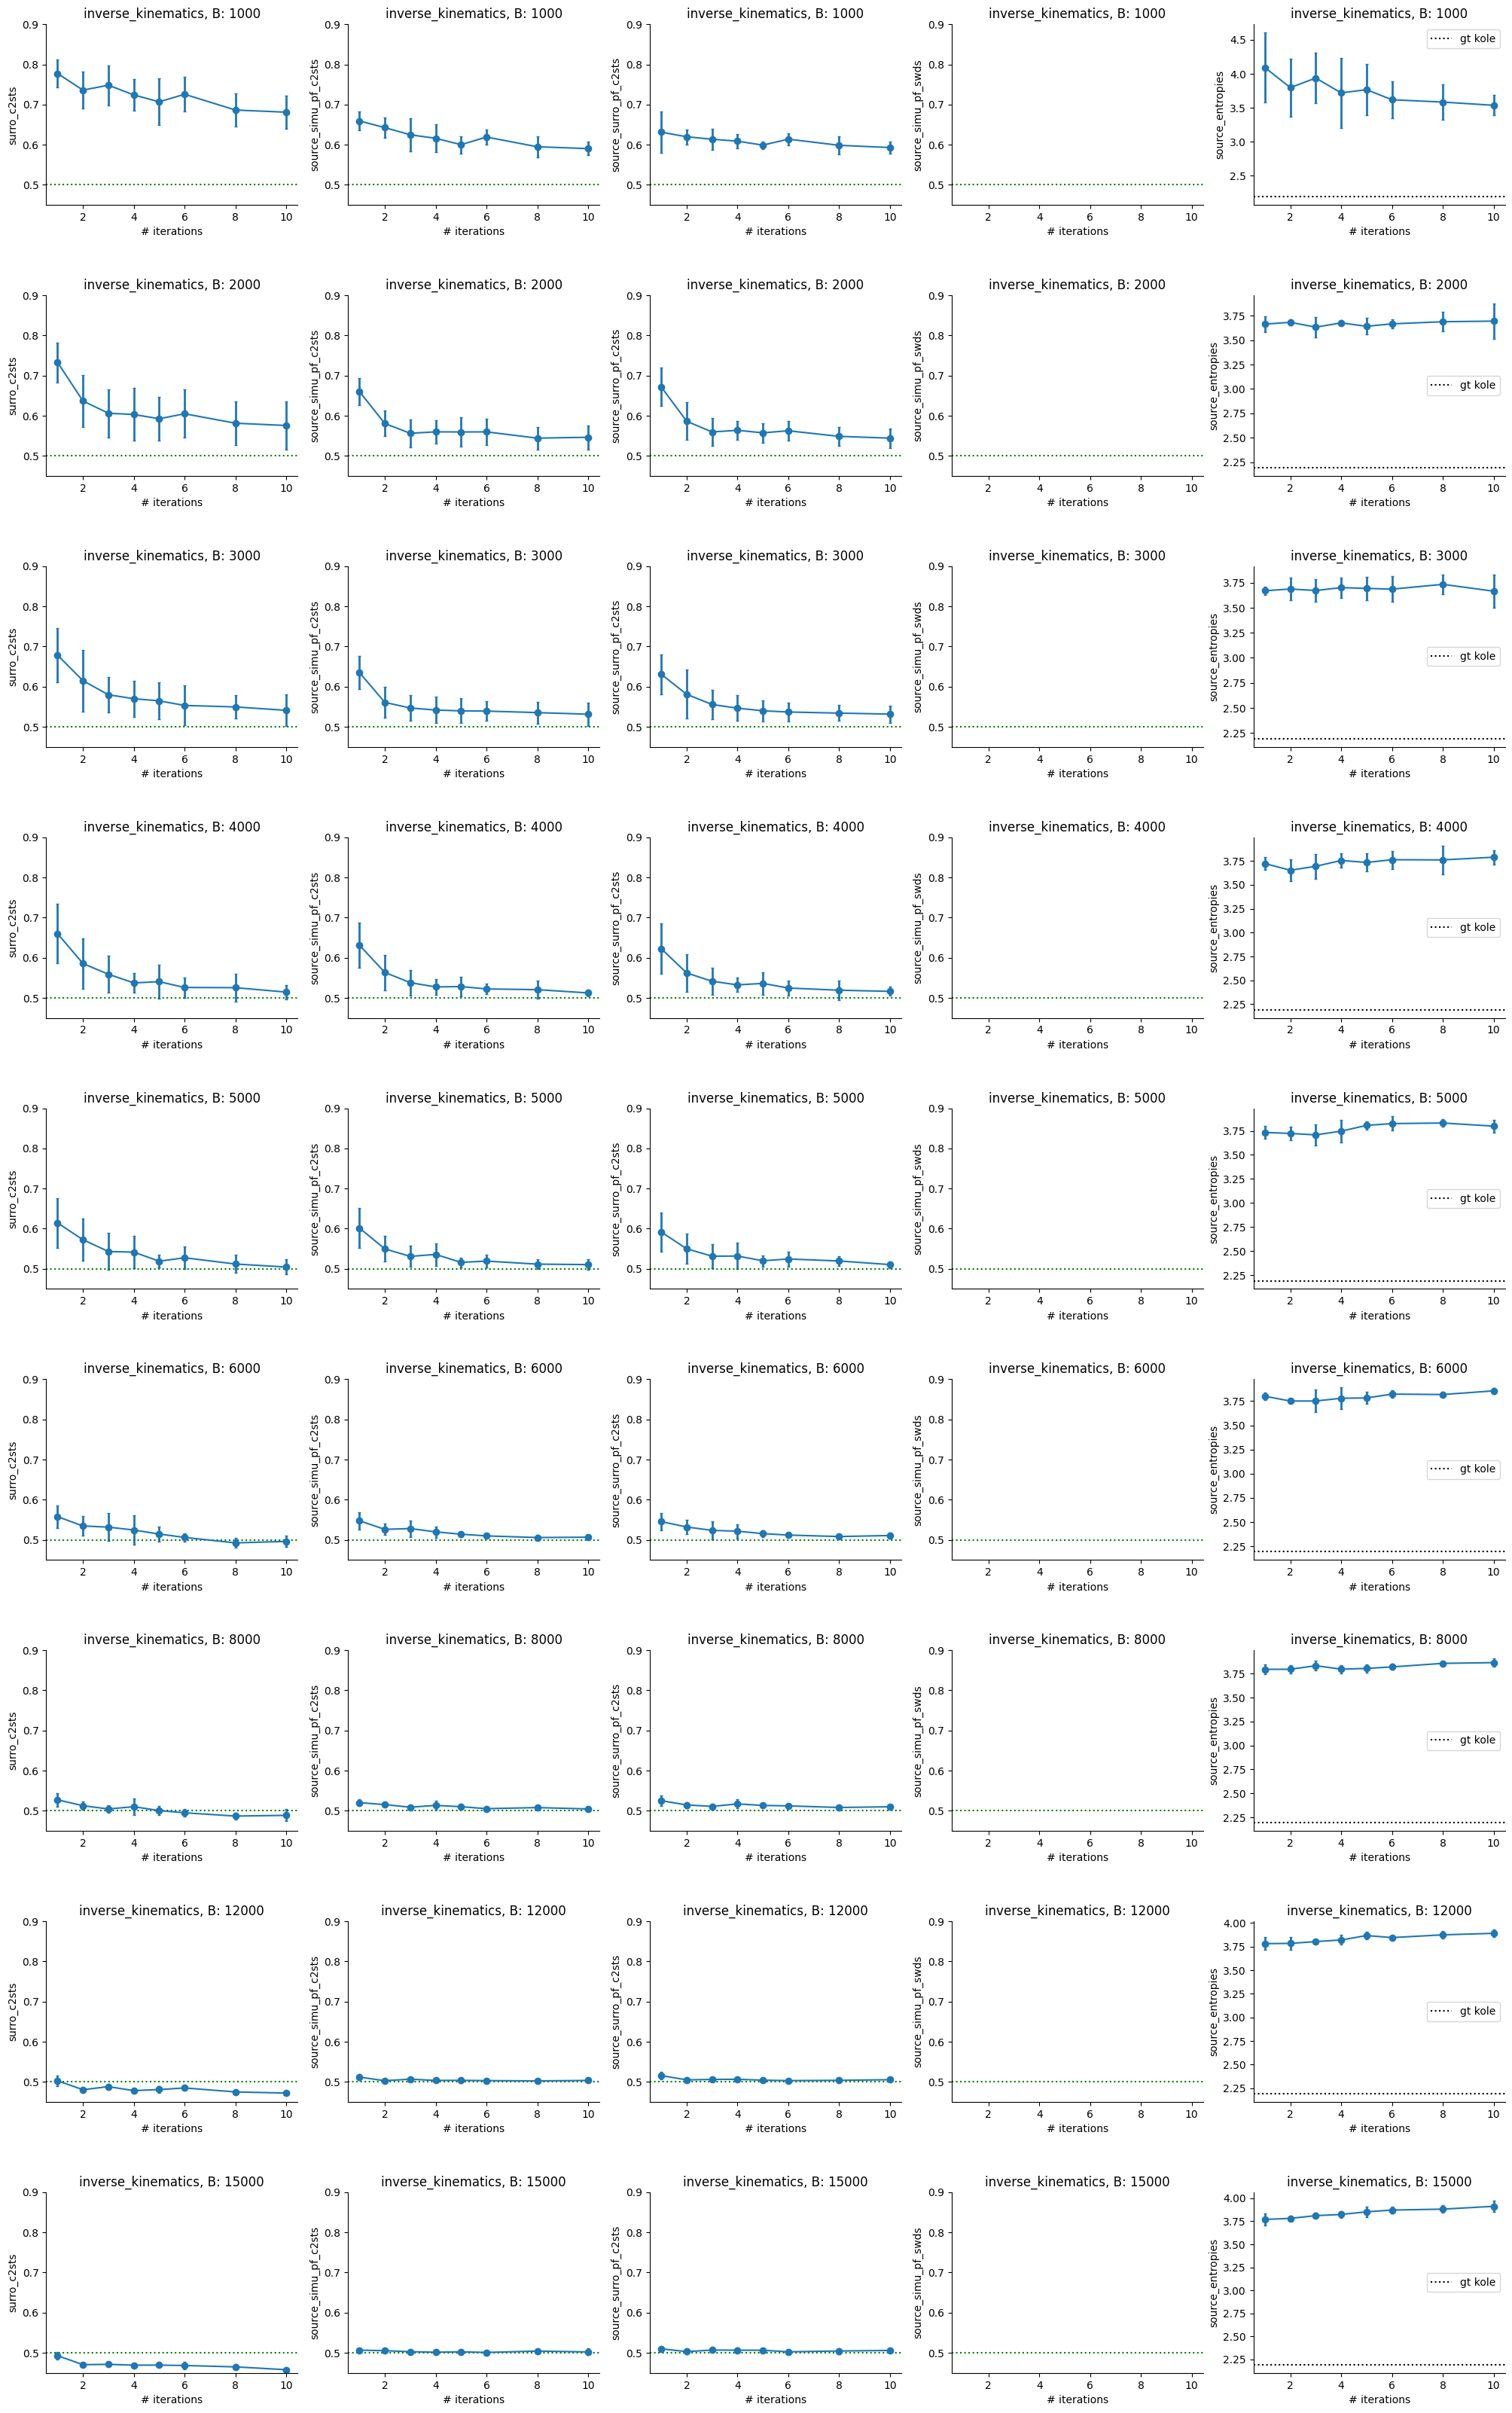

In [17]:
plot_metrics(simulator='inverse_kinematics', base_path=base_path_aggregate)
plt.show()

In [18]:
# plot_metrics(simulator='slcp', base_path=base_path_baseline)
# plt.show()

## effect aggregating data across iterations
$$
\theta_1,\dots,\theta_n\sim \Tilde{p}(\theta);\,\, x_i' \sim p(x|\theta_i) \\
x_i' \sim p(x|\theta_i) \\
\mathcal{S} \leftarrow \mathcal{S} \cup \{(\theta_i, x_i')\}_{1 \leq i \leq n}
$$

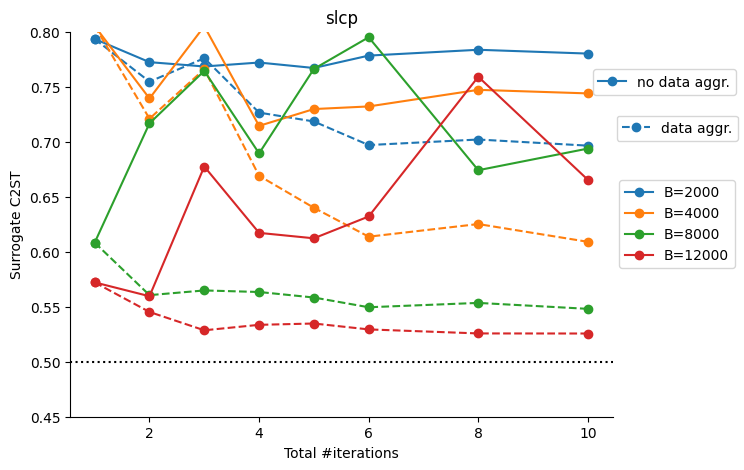

In [19]:
fig, ax = plt.subplots(figsize=(7, 5))

simulator='slcp'
metric_idx = 0

plt_baselines = []
plt_aggregates = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for bidx, b in enumerate([2000, 4000, 8000, 12_000]):
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_baseline,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p1, = ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b}")
    plt_baselines.append(p1)
    
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p2, = ax.plot(ITERS, vals[:, metric_idx], 'o--',color=colors[bidx])
    plt_aggregates.append(p2)



leg1 = plt.legend(plt_baselines[0:1], ['no data aggr.'], loc='upper right', bbox_to_anchor=(1.24, 0.92))
leg2 = plt.legend(plt_aggregates[0:1], ["data aggr."], loc='upper right', bbox_to_anchor=(1.244, 0.8))
ax.add_artist(leg1); ax.add_artist(leg2)


ax.set_ylim(0.45, 0.8)
ax.axhline(0.5, color='k', ls=':')

ax.set_title(f"{simulator}")
ax.set_xlabel("Total #iterations")
ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [20]:
mean_gt_source_kole(base_path_aggregate, simulator, 15000, 2)

9.170836001361158

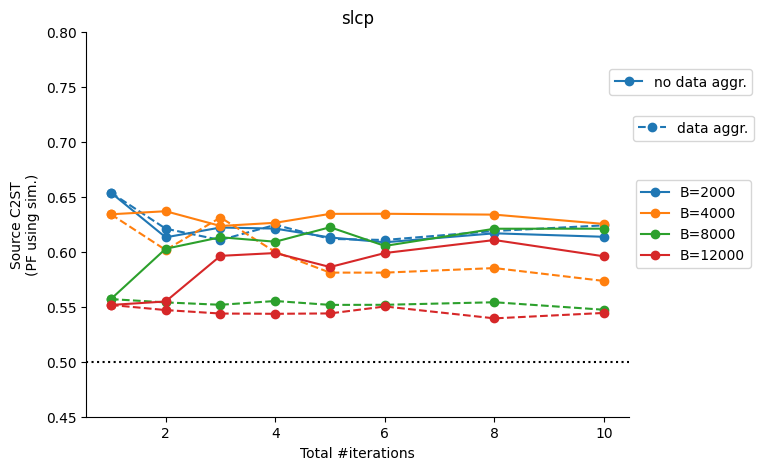

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))

simulator='slcp'
metric_idx = 1

plt_baselines = []
plt_aggregates = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for bidx, b in enumerate([2000, 4000, 8000, 12_000]):
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_baseline,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p1, = ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b}")
    plt_baselines.append(p1)
    
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p2, = ax.plot(ITERS, vals[:, metric_idx], 'o--',color=colors[bidx])
    plt_aggregates.append(p2)



leg1 = plt.legend(plt_baselines[0:1], ['no data aggr.'], loc='upper right', bbox_to_anchor=(1.24, 0.92))
leg2 = plt.legend(plt_aggregates[0:1], ["data aggr."], loc='upper right', bbox_to_anchor=(1.244, 0.8))
ax.add_artist(leg1); ax.add_artist(leg2)


ax.set_ylim(0.45, 0.8)
ax.axhline(0.5, color='k', ls=':')

ax.set_title(f"{simulator}")
ax.set_xlabel("Total #iterations")
ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

0

In [227]:
def plot_metric_multiple_budgets(base_path, simulator, metric_idx,
                                 budgets=[1000, 2000, 3000, 6000, 8000, 15_000],#, 10_000],
                                 error_bars=False,
                                 legend=True, title=True,
                                 ax=None,
                                ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for bidx, b in enumerate(budgets):
        vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
        stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
        for i, num_iters in enumerate(ITERS):
            mean_df, std_df = average_df_over_seeds(base_path, simulator, b, num_iters)
            mean_df, std_df = mean_df[METRICS_NAMES].iloc[-1:], std_df[METRICS_NAMES].iloc[-1:]
            vals[i], stds[i] = mean_df.values, std_df.values
        blabel = f"B={b // 1000}k" #f"B={b:,}"
        if error_bars:
            std_dev = stds[:, metric_idx]
            std_err = std_dev / np.sqrt(len(SEEDS[simulator]))
            ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=std_err, capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=blabel)
        else:
            ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b:,}")

    ax.set_xticks(ITERS)  

    if METRICS_NAMES[metric_idx] in ['surro_c2sts', 'source_simu_pf_c2sts', 'source_surro_pf_c2sts']:
        ax.axhline(0.5, color='k', ls=':')
        ax.set_ylim(0.45, 0.85)
        if simulator == 'two_moons':
            ax.set_ylim(0.45, 0.60)
        if simulator == 'gaussian_mixture':
            ax.set_ylim(0.45, 0.70)
    if METRICS_NAMES[metric_idx] == 'source_simu_pf_swds':
        ax.axhline(mean_gt_swd(base_path, simulator, 15000, 1), color='k', ls='--', label='baseline swd') # any budget/iter work here
        handles, _ = ax.get_legend_handles_labels()
        print(handles)
        # Slice list to remove budgets
        if error_bars:
            ax.legend(handles = handles[:1])
        else:
            ax.legend(handles = handles[-1:])
    if METRICS_NAMES[metric_idx] == 'source_entropies':
        ax.axhline(mean_gt_source_kole(base_path, simulator, 15000, 1), color='r', ls='--', label='gt kole') # any budget/iter work here

    if title:
        ax.set_title(f"Simulator: {simulator}", fontsize=15)
    ax.set_xlabel(r"Total #iterations (I)", fontsize=15)
    ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]], fontsize=15)   
    if legend:
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3, fontsize=10)
        ax.legend(loc='center left', bbox_to_anchor=(0.12, 0.83), ncols=3, fontsize=10)
    # return ax

## Results for the benchmark simulators

[<matplotlib.lines.Line2D object at 0x2af5ae6e0>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>]


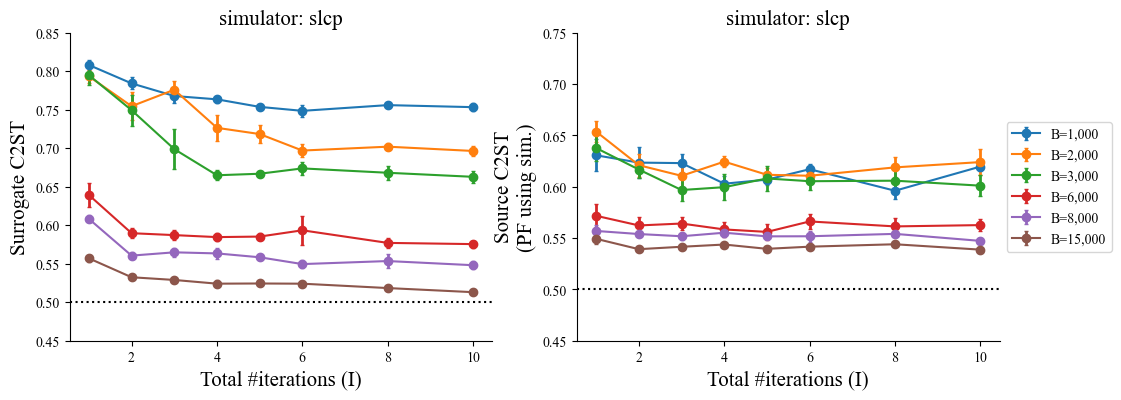

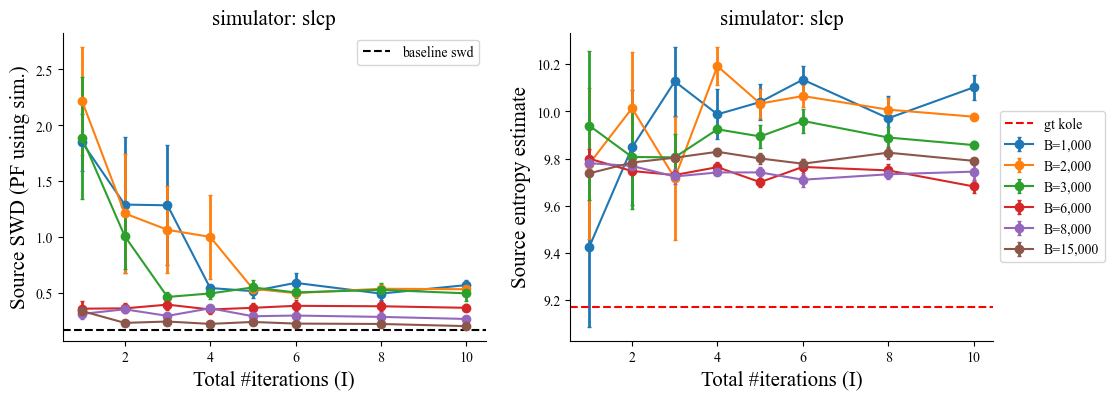

In [115]:
simulator='slcp'
error_bars = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True, error_bars=error_bars)
axes[1].set_ylim(0.45, 0.75)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True, error_bars=error_bars)

plt.show()

[<matplotlib.lines.Line2D object at 0x2c9f73460>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>]


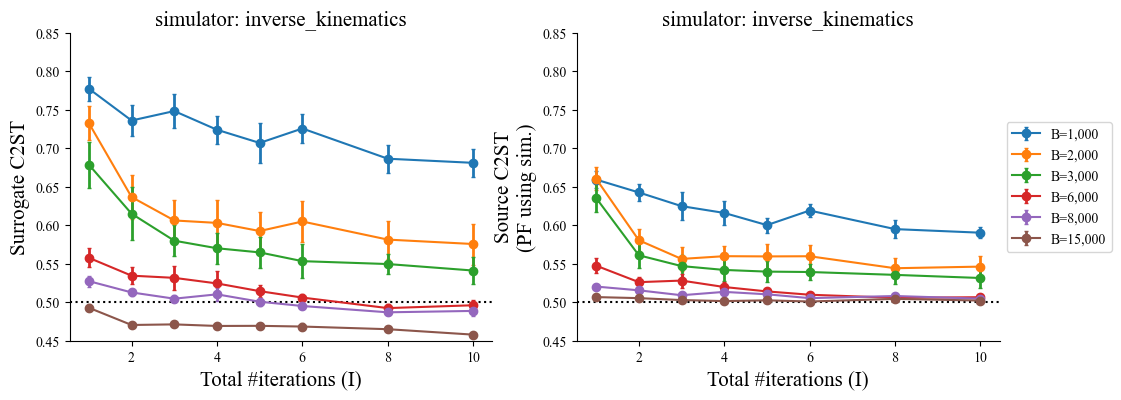

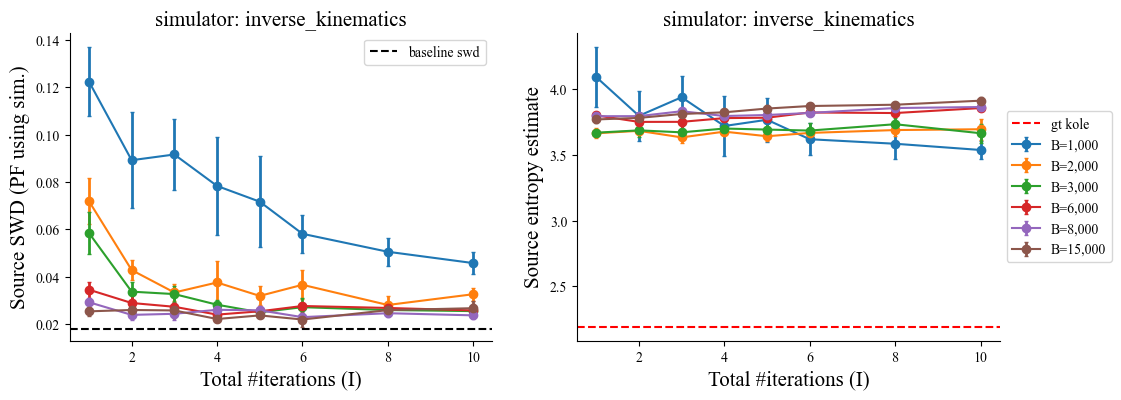

In [116]:
simulator='inverse_kinematics'
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True, error_bars=error_bars)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True, error_bars=error_bars)

plt.show()

[<matplotlib.lines.Line2D object at 0x2ca6979a0>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>]


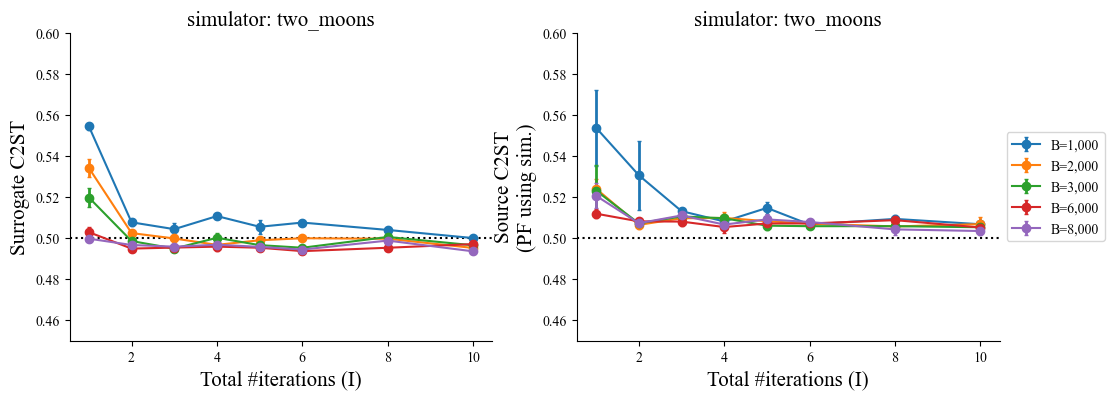

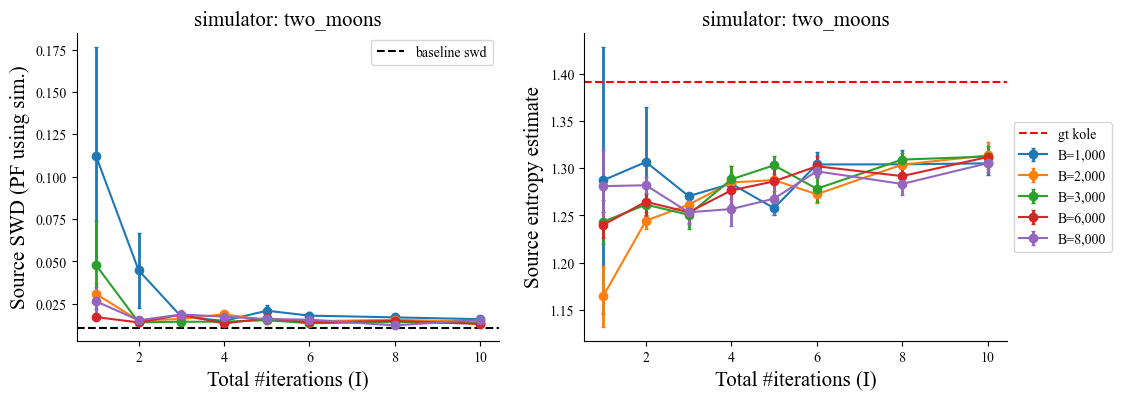

In [66]:
simulator='two_moons'
error_bars=True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True, error_bars=error_bars)
axes[0].set_ylim(0.45, 0.6); axes[1].set_ylim(0.45, 0.6)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True, error_bars=error_bars)

plt.show()

[<matplotlib.lines.Line2D object at 0x2ca3d9450>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>]


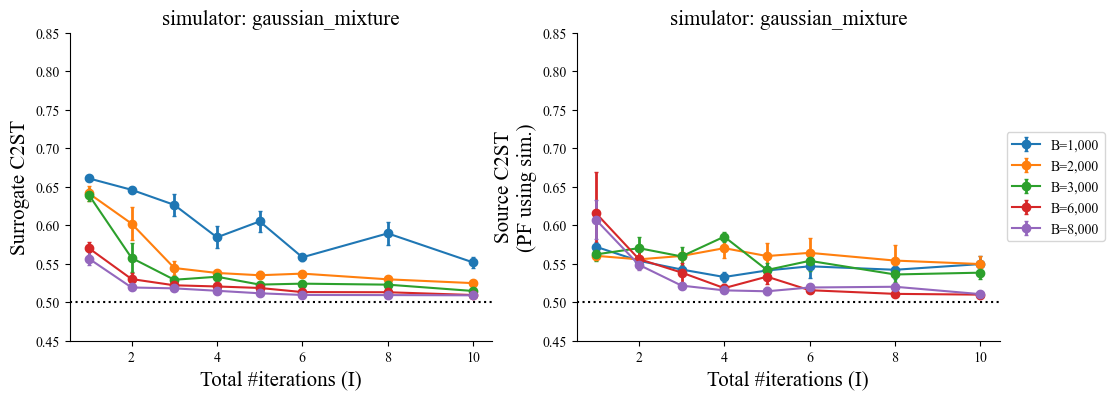

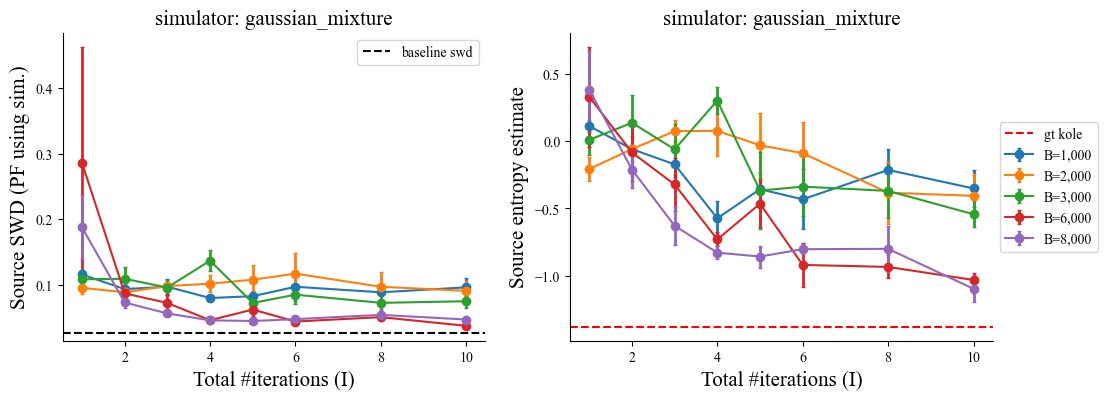

In [67]:
simulator='gaussian_mixture'
error_bars=True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True, error_bars=error_bars)
# axes[0].set_ylim(0.45, 0.7); axes[1].set_ylim(0.45, 0.7)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True, error_bars=error_bars)

plt.show()

ik


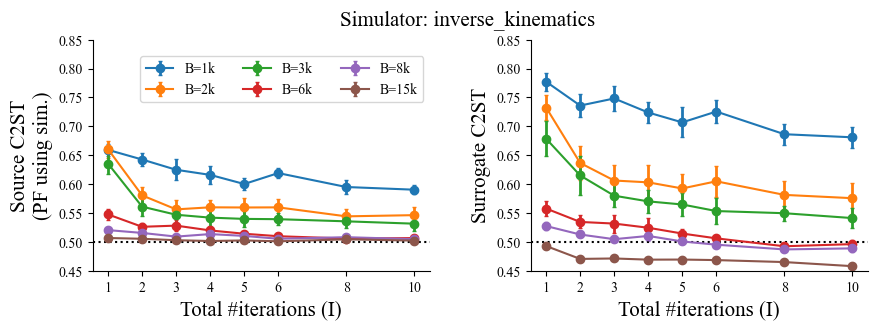

In [183]:
## paper plots
simulator='inverse_kinematics'
simulator_short_name = ''.join([word[0] for word in simulator.split('_')])
print(simulator_short_name)
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1), gridspec_kw={'wspace':0.3,'hspace':0.1})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[0], legend=True, title=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[1], legend=False, title=False, error_bars=error_bars)


fig.suptitle(f"Simulator: {simulator}", fontsize=15)
# fig.tight_layout()
plt.savefig(f"./figures/{simulator_short_name}_source_and_surrogate_final_C2STs_vs_budgets.pdf", bbox_inches='tight')
plt.show()

s


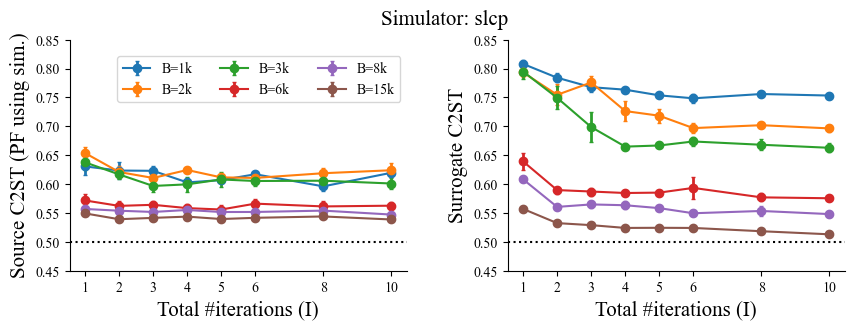

In [222]:
## paper plots
simulator='slcp'
simulator_short_name = ''.join([word[0] for word in simulator.split('_')])
print(simulator_short_name)
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1), gridspec_kw={'wspace':0.3,'hspace':0.1})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[0], legend=True, title=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[1], legend=False, title=False, error_bars=error_bars)


fig.suptitle(f"Simulator: {simulator}", fontsize=15)
# fig.tight_layout()
plt.savefig(f"./figures/{simulator_short_name}_source_and_surrogate_final_C2STs_vs_budgets.pdf", bbox_inches='tight')
plt.show()

tm


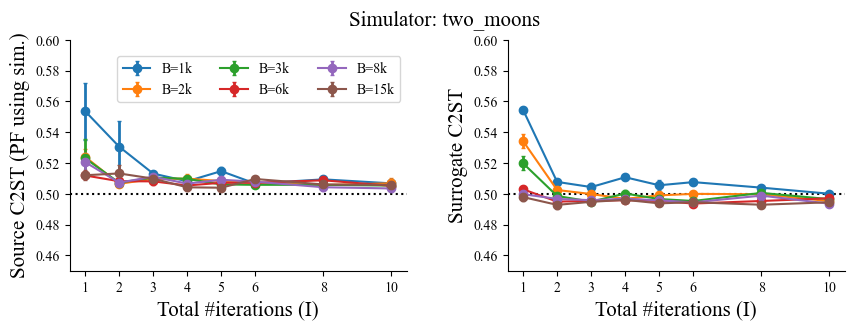

In [225]:
## paper plots
simulator='two_moons'
simulator_short_name = ''.join([word[0] for word in simulator.split('_')])
print(simulator_short_name)
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1), gridspec_kw={'wspace':0.3,'hspace':0.1})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[0], legend=True, title=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[1], legend=False, title=False, error_bars=error_bars)


fig.suptitle(f"Simulator: {simulator}", fontsize=15)
# fig.tight_layout()
plt.savefig(f"./figures/{simulator_short_name}_source_and_surrogate_final_C2STs_vs_budgets.pdf", bbox_inches='tight')
plt.show()

gm


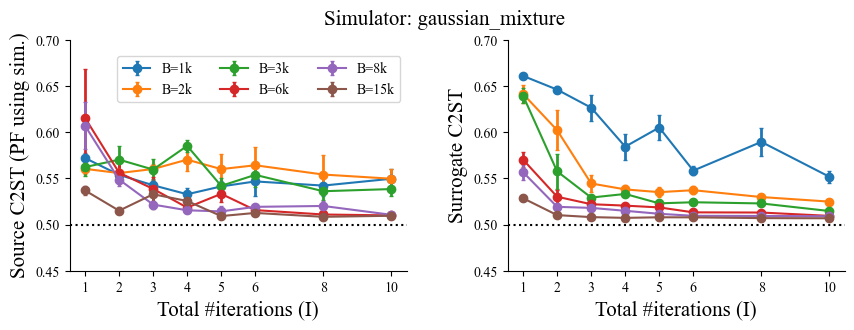

In [228]:
## paper plots
simulator='gaussian_mixture'
simulator_short_name = ''.join([word[0] for word in simulator.split('_')])
print(simulator_short_name)
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1), gridspec_kw={'wspace':0.3,'hspace':0.1})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[0], legend=True, title=False, error_bars=error_bars)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[1], legend=False, title=False, error_bars=error_bars)


fig.suptitle(f"Simulator: {simulator}", fontsize=15)
# fig.tight_layout()
plt.savefig(f"./figures/{simulator_short_name}_source_and_surrogate_final_C2STs_vs_budgets.pdf", bbox_inches='tight')
plt.show()

## meeting notes 27.11.24:

1. active source estimation
- problem with the ASNPE paper, if you have N=1M, and B=1000 --> would you not sample the same "good" examples again and again? duplicates issue
- active source estimation vs. active snpe-c/sbi: also in source estimation we have many x-s --> uncertainty kind of averages out. unlike sbi, where we just want to focus on a single observation $x_o$
- 


2. ensemble of surrogates or bayesian neural networks surrogate
- we have fitted a source, now we need to sample new theta-s
- now where can we sample thetas to have the greatest impact on improving the surrogate?
- we sample x ~ p(x|θ) from the simulator to update the surrogate, which x-s would be more informative to train the surrogate?
- the θ-s which can possibly generate a greater variety of x-s => p(x|θ) is a high variance (?) distribution -- how do we identify such θ-s?
- need to design a proposal distribution (to sample θ-s instead of directly sampling from the source) which takes into account the source estimated so far, and the surrogate _uncertainty_, and then generates the θ-s to simulate observations from
- Thus the dataset to update the surrogate should contain θ-s where the simulator is more uncertain?


3. read the paper: Learning Diffusion Priors from Observations by Expectation Maximization
- useful for high dimensional problems? how?
- nice excuse to start learning about diffusion models I guess
- for masters thesis, need send an email to mls-jobs

3. hodgkin-huxley experiments:
- once we have some results, I can start writing the report --- from research project perspective should be enough?
- some workshop paper out of it?

## bubble chart
- this chart visualizes all (B, I) pairs at the same time
- bubble size and color ("deepness") is proportional to the C2ST
- so smaller and darker bubbles are good!

In [85]:
ALL_BUDGETS = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 12_000, 15_000] # yaxis
ALL_ITERS = [1, 2, 3, 4, 5, 6, 8, 10] # xaxis
ALL_METRICS_MEANS = {}
ALL_METRICS_STDS = {}
simulator = 'inverse_kinematics'


for bidx, b in enumerate(ALL_BUDGETS):
    ALL_METRICS_MEANS[b] = {}
    ALL_METRICS_STDS[b] = {}
    for i, num_iters in enumerate(ALL_ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate, simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        ALL_METRICS_MEANS[b][num_iters] = mean_df
        ALL_METRICS_STDS[b][num_iters] = std_df

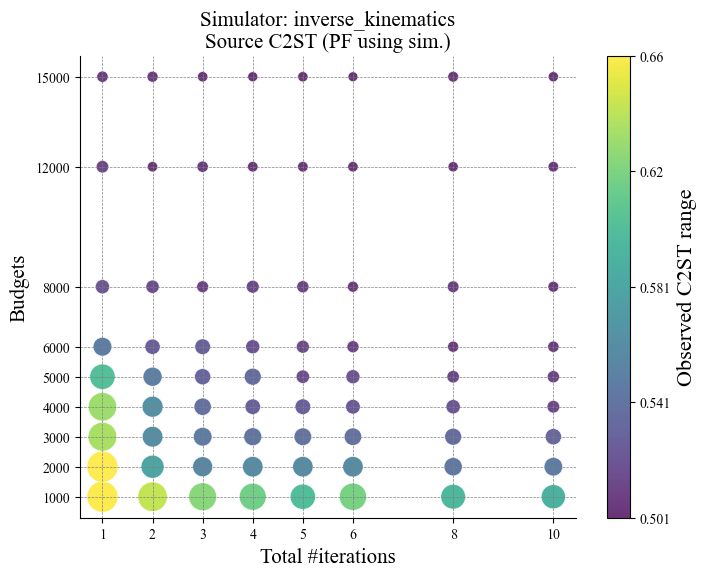

In [189]:
from sklearn.preprocessing import MinMaxScaler
# Your dataset
x = np.array([1, 2, 3, 4,5, 6, 8, 10])
y = np.array([1000, 2000, 3000, 4000, 5000, 6000, 8000, 12000, 15000])

# Create coordinate grids
x_coords = np.repeat(x.reshape(1, -1), len(y), 0).flatten()
y_coords = np.repeat(y, len(x))

metric_idx=1
metric_name = METRICS_NAMES[metric_idx]
# get the values at each coordinate
values_flat = []
for xc, yc in zip(x_coords, y_coords):
    values_flat.append(
        ALL_METRICS_MEANS[yc][xc][metric_name].item()
    )
values_flat = np.array(values_flat)

# Step 1: Normalize sizes
scaler = MinMaxScaler(feature_range=(50, 500))  # Bubble sizes in pixels
sizes = scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 2: Normalize colors
color_scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize for colormap
colors = color_scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 3: Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x_coords, y_coords,
    s=sizes,  # Use normalized sizes
    c=colors,  # Use normalized colors
    cmap='viridis',  # Colormap for gradient
    alpha=0.8,  # Slight transparency for better visual layering
    edgecolors='w',  # White edges for clarity
    linewidth=0.5
)


# Step 4: Customize gridlines
plt.xticks(x)  # Set ticks for x-axis at specific x values
plt.yticks(y)  # Set ticks for y-axis at specific y values
plt.grid(visible=True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

# Add a colorbar for reference
# plt.colorbar(scatter, label='Normalized Value')
# Step 4: Adjust the colorbar to reflect original values
cbar = plt.colorbar(scatter, label='Observed C2ST range')
cbar.set_label('Observed C2ST range', fontsize=16)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])  # Adjust ticks for normalized colors
cbar.set_ticklabels(np.linspace(values_flat.min(), values_flat.max(), 5).round(3))  # Map to original range

# Label the axes
plt.xlabel("Total #iterations", fontsize=15)
plt.ylabel("Budgets", fontsize=15)
plt.title(f"Simulator: {simulator}\n{METRICS_LABELS[metric_name]}", fontsize=15)

# Display the plot
# plt.show()
plt.savefig(f"./figures/{simulator}_bubble_chart_{METRICS_NAMES[metric_idx]}.pdf")

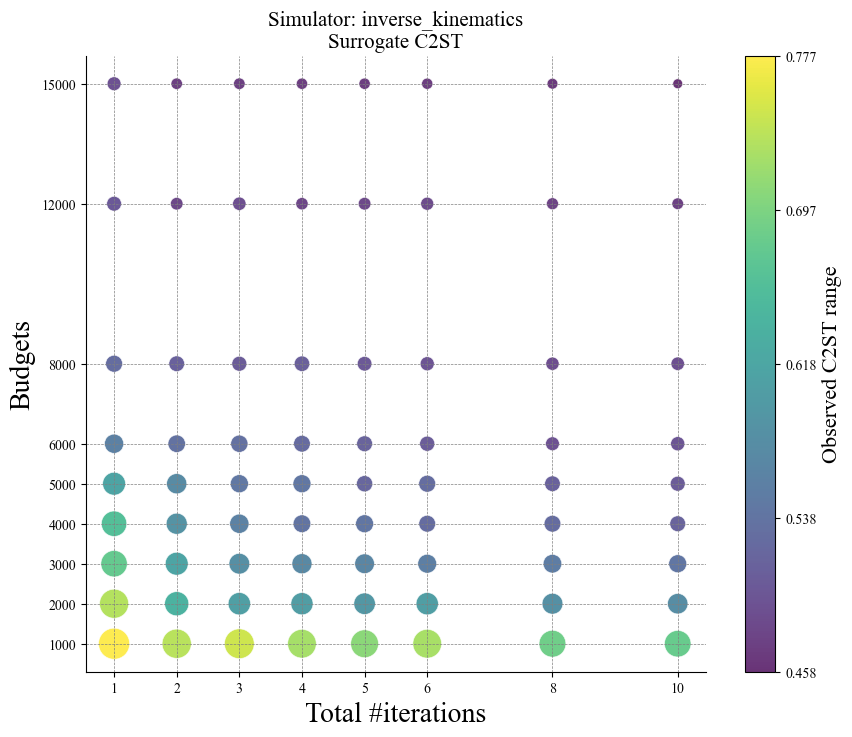

In [87]:
# Your dataset
x = np.array([1, 2, 3, 4,5, 6, 8, 10])
y = np.array([1000, 2000, 3000, 4000, 5000, 6000, 8000, 12000, 15000])
# Your dataset
# x = np.array([1, 2, 3, 4, 8, 10])
# y = np.array([1000, 2000, 3000, 4000, 5000, 6000, 8000, 12000, 15000])

# Create coordinate grids
x_coords = np.repeat(x.reshape(1, -1), len(y), 0).flatten()
y_coords = np.repeat(y, len(x))

metric_name = 'surro_c2sts'
# get the values at each coordinate
values_flat = []
for xc, yc in zip(x_coords, y_coords):
    values_flat.append(
        ALL_METRICS_MEANS[yc][xc][metric_name].item()
    )
values_flat = np.array(values_flat)

# Step 1: Normalize sizes
scaler = MinMaxScaler(feature_range=(50, 500))  # Bubble sizes in pixels
sizes = scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 2: Normalize colors
color_scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize for colormap
colors = color_scaler.fit_transform(values_flat.reshape(-1, 1)).flatten()

# Step 3: Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x_coords, y_coords,
    s=sizes,  # Use normalized sizes
    c=colors,  # Use normalized colors
    cmap='viridis',  # Colormap for gradient
    alpha=0.8,  # Slight transparency for better visual layering
    edgecolors='w',  # White edges for clarity
    linewidth=0.5
)

# Step 4: Customize gridlines
plt.xticks(x)  # Set ticks for x-axis at specific x values
plt.yticks(y)  # Set ticks for y-axis at specific y values
plt.grid(visible=True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

# Add a colorbar for reference
# plt.colorbar(scatter, label='Normalized Value')
# Step 4: Adjust the colorbar to reflect original values
cbar = plt.colorbar(scatter, label='Observed C2ST range')
cbar.set_label('Observed C2ST range', fontsize=16)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])  # Adjust ticks for normalized colors
cbar.set_ticklabels(np.linspace(values_flat.min(), values_flat.max(), 5).round(3))  # Map to original range

# Label the axes
plt.xlabel("Total #iterations", fontsize=20)
plt.ylabel("Budgets", fontsize=20)
plt.title(f"Simulator: {simulator}\n{METRICS_LABELS[metric_name]}", fontsize=15)

# Display the plot
# plt.show()
plt.savefig(f"./figures/{simulator}_bubble_chart_{METRICS_NAMES[metric_idx]}.pdf")

## budget efficiency plots
In all the previous plots, we show the metric value attained after all the iterations are done in the sequential method. How does C2ST evolve
after each single iteration for a fixed (B, I) pair? How much fraction of the total one-shot budget (B) does it take to reach the same level 
of performance?

In [217]:
def make_budget_efficiency_plot(simulator, metric_idx, budget, iters=ITERS,
                                error_bars=False, ax=None, relative=False, legend=True,
                                title=False,
                               ):
    strategies = {}
    strategy_budgets = {}
    std_devs = {}
    
    
    metric_idx = metric_idx
    metric = METRICS_NAMES[metric_idx]

    ITERS = iters
    
    for budg in [budget]:
        one_shot_budget = budg
        one_shot_metric = average_df_over_seeds(base_path_aggregate, simulator, one_shot_budget, 1)[0][metric].item()
        # get results
        for it in ITERS:
            strategies[f"{it}x{budg//it}"] = np.array(average_df_over_seeds(base_path_aggregate, simulator, one_shot_budget, it)[0][metric].to_list())
            strategy_budgets[f"{it}x{budg//it}"] = np.cumsum((budg//it) * np.ones(it))
            std_devs[f"{it}x{budg//it}"] = np.array(average_df_over_seeds(base_path_aggregate, simulator, one_shot_budget, it)[1][metric].to_list())

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Plot each sequential strategy with error bands
    for strategy, metrics in strategies.items():
        budgets = strategy_budgets[strategy]
        std_dev = std_devs[strategy]  # Get corresponding std deviations
        std_err = std_dev / np.sqrt(len(SEEDS[simulator]))
        
        # Compute relative performance gain
        relative_performance = metrics / one_shot_metric  # Normalize by one-shot metric
        budget_fraction = budgets / one_shot_budget  # Normalize budget fraction
    
        # Compute upper and lower bounds for error bands
        lower_bound = (metrics - std_err)
        upper_bound = (metrics + std_err)
        if relative:
            lower_bound = lower_bound / one_shot_metric
            upper_bound = upper_bound / one_shot_metric

        # Plot efficiency curve
        if relative:
            ax.plot(budget_fraction, relative_performance, marker='o', linestyle='-', label=f"I = {strategy.split('x')[0]}")
        else:
            ax.plot(budget_fraction, metrics, marker='o', linestyle='-', label=f"I = {strategy.split('x')[0]}")
    
        # Plot error bands using fill_between
        if error_bars:
            ax.fill_between(budget_fraction, lower_bound, upper_bound, alpha=0.2)
    
    # Add reference line for one-shot method (100% budget, 100% performance)
    if relative:
        ax.axhline(y=1.0, color='k', linestyle='--', label="One-shot baseline")
    else:
        ax.axhline(y=one_shot_metric, color='k', linestyle='--', label="One-shot baseline")
    
    # Labels and Title
    ax.set_xlabel(f"Fraction of the total simulation budget ({one_shot_budget}) used", fontsize=18)
    if relative:
        ax.set_ylabel("Relative performance gain\n(Sequential C2ST / One-shot C2ST)", fontsize=18)
    else:
        ax.set_ylabel(f"{METRICS_LABELS[metric]}", fontsize=18)
    if title:
        ax.set_title(rf"Simulator: {simulator}, with B={budg}", fontsize=15)
    # ax.set_title(rf"Budget Efficiency: Sequential vs. One-shot $Sourcerer$, simulator: {simulator}")
    
    # Grid, Legend, and Styling
    if legend:
        ax.legend(fontsize=15)
    ax.grid(visible=True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

Source C2ST
(PF using sim.)


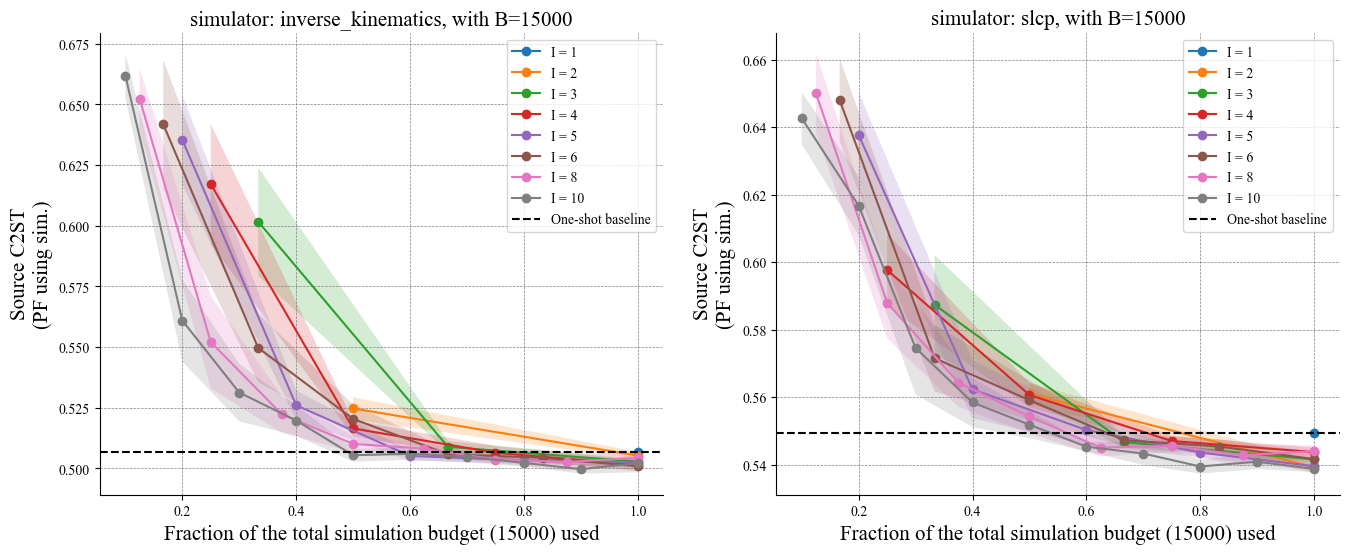

In [118]:
metric_idx=1
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=15_000
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator='inverse_kinematics', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[0])

make_budget_efficiency_plot(simulator='slcp', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[1])

plt.show()

In [108]:
# metric_idx=1
# print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
# budget=12_000
# error_bars=True

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
# make_budget_efficiency_plot(simulator='inverse_kinematics', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[0], relative=True)

# make_budget_efficiency_plot(simulator='slcp', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[1], relative=True)

# plt.show()

Source C2ST
(PF using sim.)


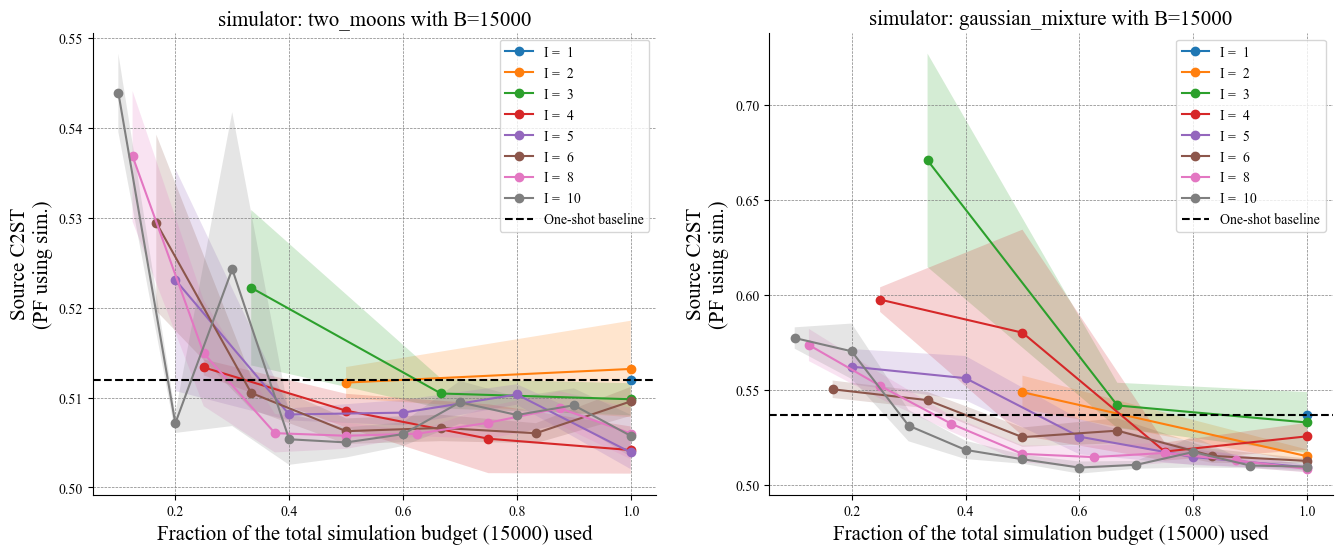

In [109]:
metric_idx=1
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=15_000
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator='two_moons', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[0])

make_budget_efficiency_plot(simulator='gaussian_mixture', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[1])

plt.show()

Surrogate C2ST


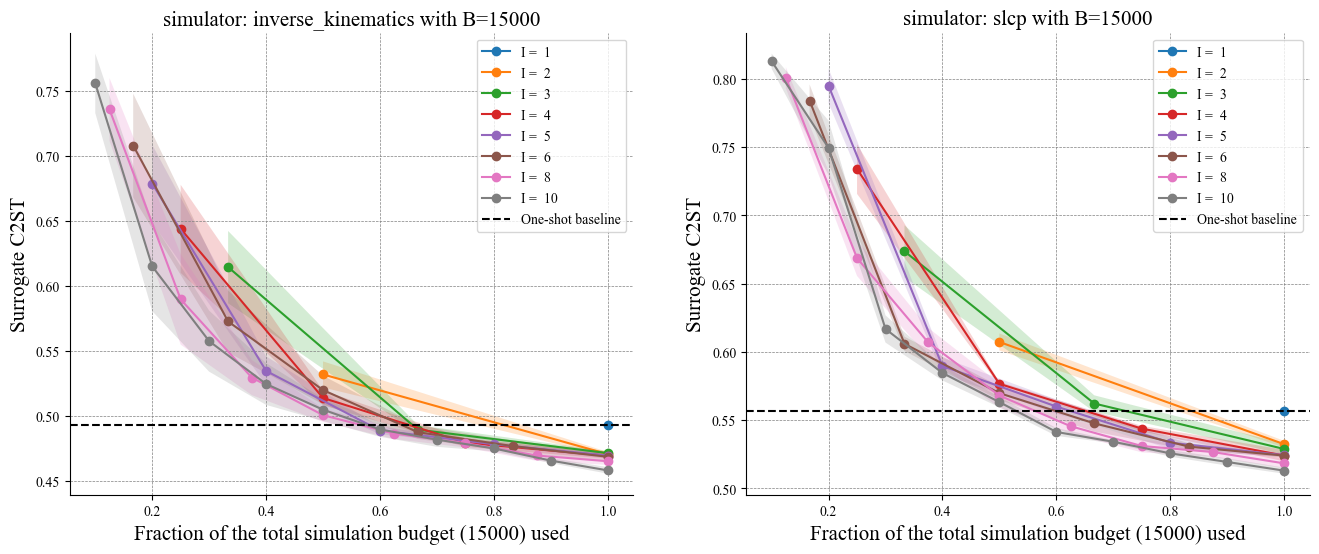

In [110]:
metric_idx=0
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=15_000
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator='inverse_kinematics', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[0])

make_budget_efficiency_plot(simulator='slcp', metric_idx=metric_idx, budget=budget, error_bars=error_bars, ax=axes[1])

plt.show()

Source C2ST (PF using sim.)


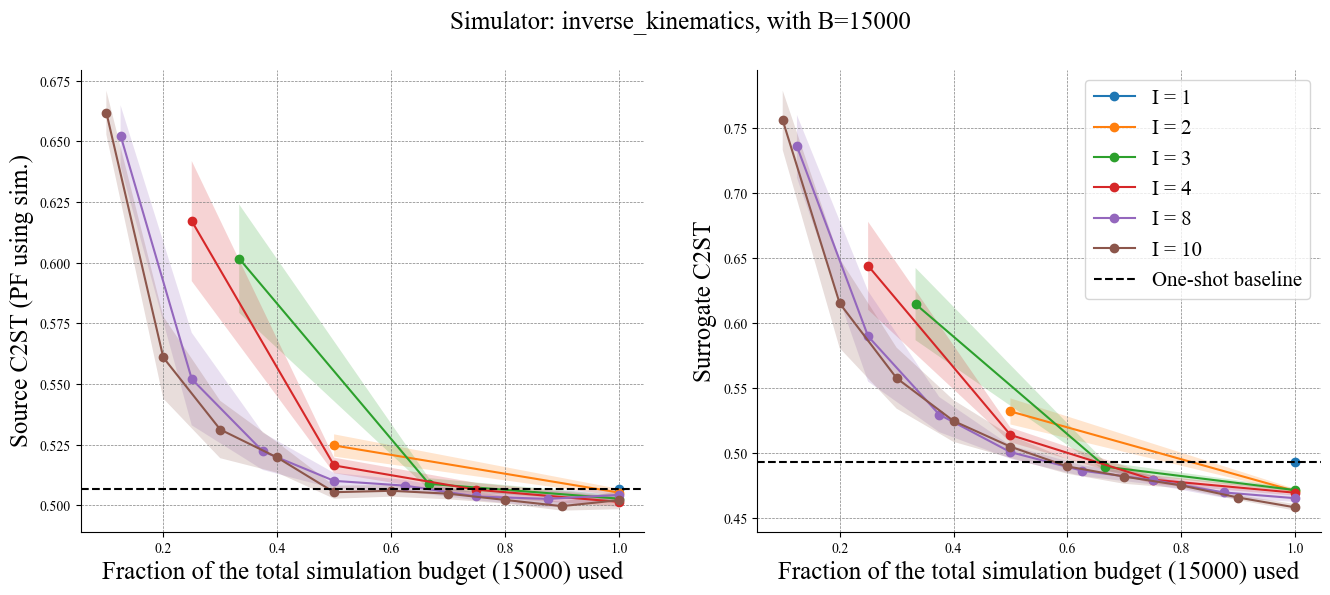

In [218]:
metric_idx=1
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=15_000
iters = [1, 2, 3, 4, 8, 10]
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator='inverse_kinematics', metric_idx=1, budget=budget, iters=iters, error_bars=error_bars, ax=axes[0], legend=False, title=False)
make_budget_efficiency_plot(simulator='inverse_kinematics', metric_idx=0, budget=budget,iters=iters, error_bars=error_bars, ax=axes[1], title=False)

fig.suptitle(f"Simulator: {simulator}, with B={budget}", fontsize=18)

plt.savefig(f"./figures/{simulator}_budget_efficiency_{budget}.pdf", bbox_inches='tight')
plt.show()

Source C2ST (PF using sim.)


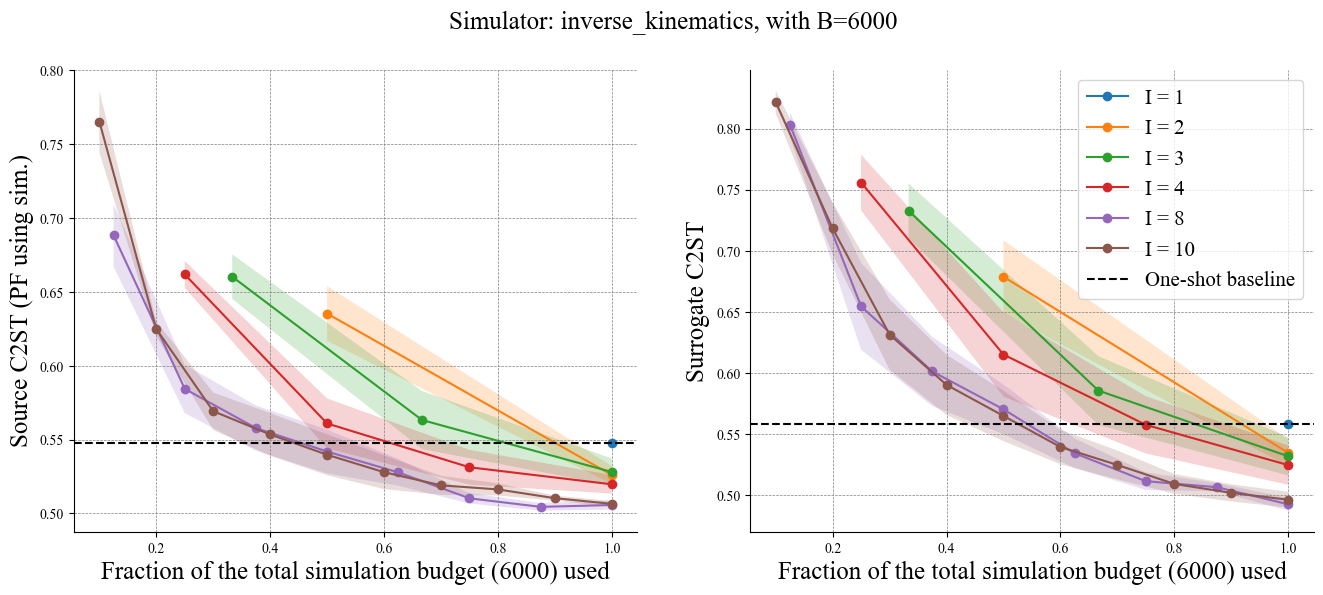

In [221]:
metric_idx=1
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=6_000
iters = [1, 2, 3, 4, 8, 10]
error_bars=True

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator='inverse_kinematics', metric_idx=1, budget=budget, iters=iters, error_bars=error_bars, ax=axes[0], legend=False, title=False)
make_budget_efficiency_plot(simulator='inverse_kinematics', metric_idx=0, budget=budget,iters=iters, error_bars=error_bars, ax=axes[1], title=False)

fig.suptitle(f"Simulator: {simulator}, with B={budget}", fontsize=18)

plt.savefig(f"./figures/{simulator}_budget_efficiency_{budget}.pdf", bbox_inches='tight')
plt.show()

Source C2ST (PF using sim.)


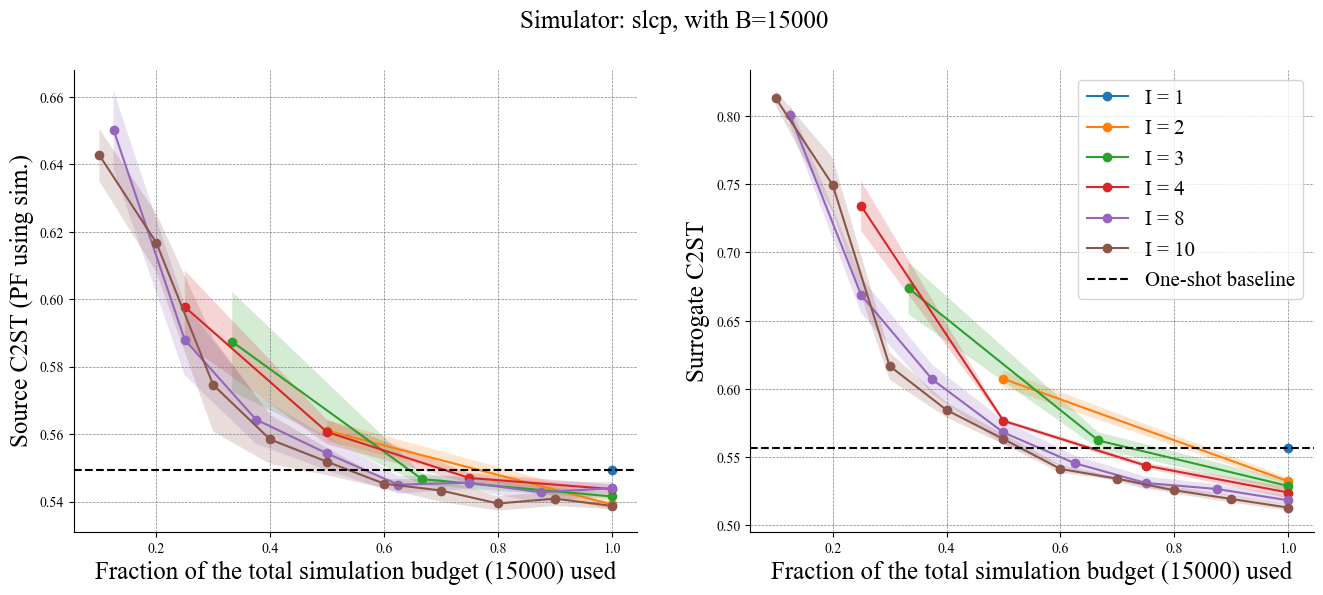

In [235]:
metric_idx=1
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=15_000
iters = [1, 2, 3, 4, 8, 10]
error_bars=True

simulator = 'slcp'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator=simulator, metric_idx=1, budget=budget, iters=iters, error_bars=error_bars, ax=axes[0], legend=False, title=False)
make_budget_efficiency_plot(simulator=simulator, metric_idx=0, budget=budget,iters=iters, error_bars=error_bars, ax=axes[1], title=False)

fig.suptitle(f"Simulator: slcp, with B={budget}", fontsize=18)

plt.savefig(f"./figures/slcp_budget_efficiency_{budget}.pdf", bbox_inches='tight')
plt.show()

Source C2ST (PF using sim.)


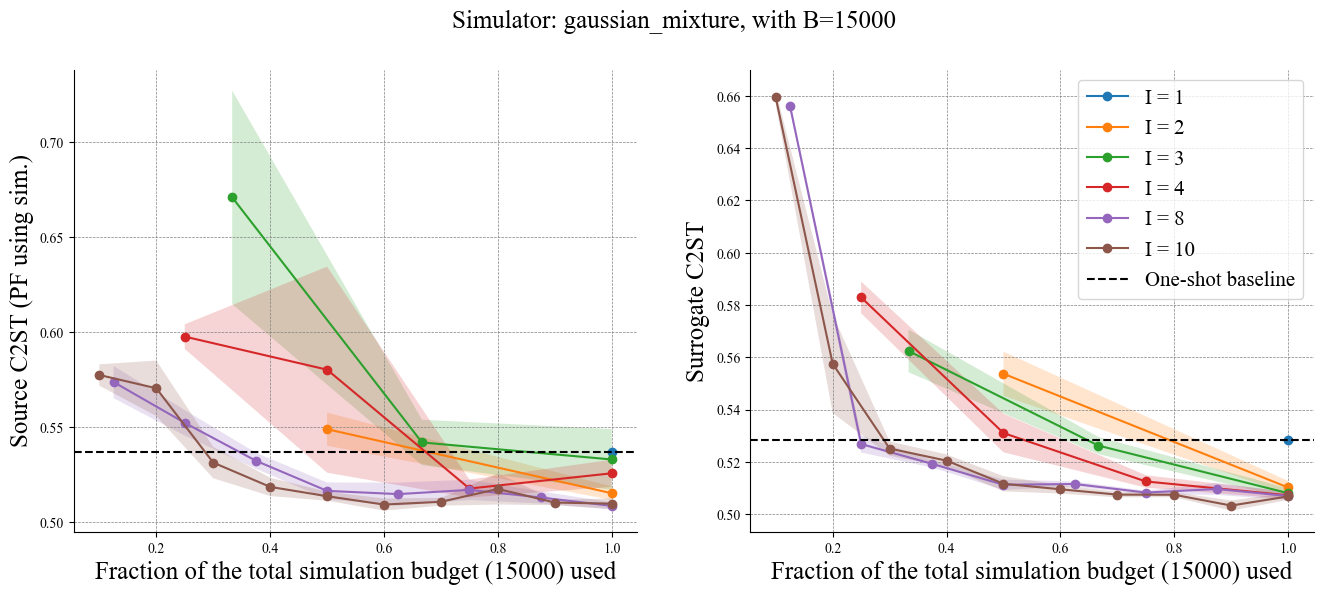

In [236]:
metric_idx=1
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=15_000
iters = [1, 2, 3, 4, 8, 10]
error_bars=True

simulator = 'gaussian_mixture'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator=simulator, metric_idx=1, budget=budget, iters=iters, error_bars=error_bars, ax=axes[0], legend=False, title=False)
make_budget_efficiency_plot(simulator=simulator, metric_idx=0, budget=budget,iters=iters, error_bars=error_bars, ax=axes[1], title=False)

fig.suptitle(f"Simulator: {simulator}, with B={budget}", fontsize=18)

plt.savefig(f"./figures/{simulator}_budget_efficiency_{budget}.pdf", bbox_inches='tight')
plt.show()

Source C2ST (PF using sim.)


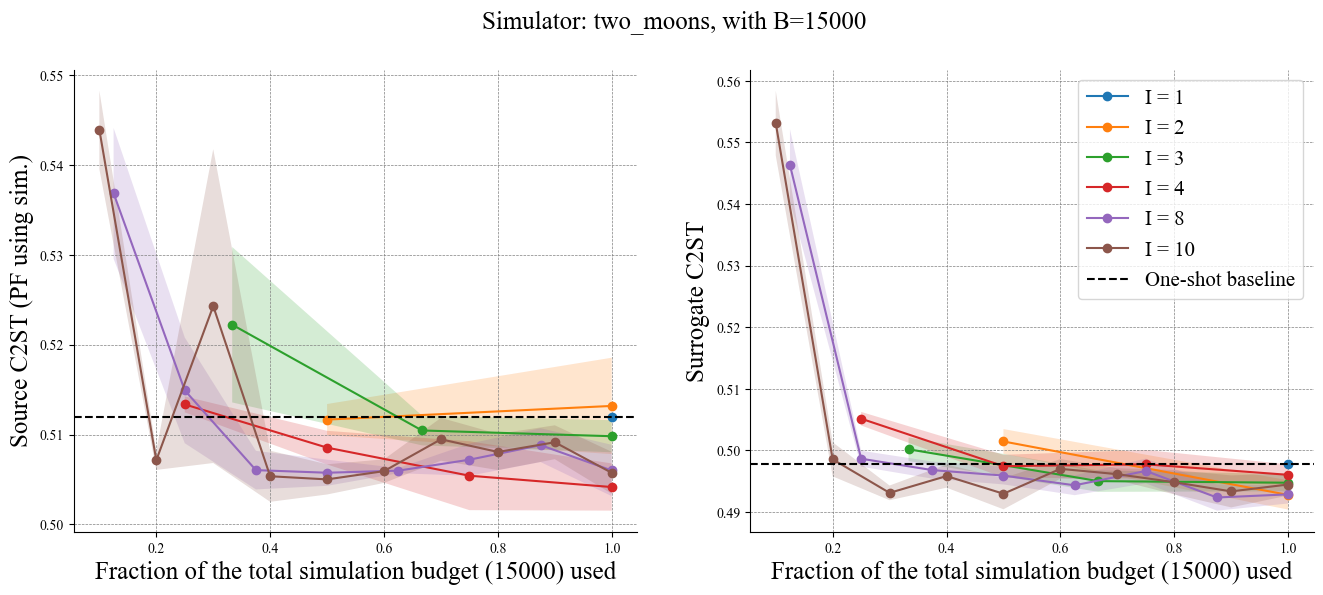

In [237]:
metric_idx=1
print(METRICS_LABELS[METRICS_NAMES[metric_idx]])
budget=15_000
iters = [1, 2, 3, 4, 8, 10]
error_bars=True

simulator = 'two_moons'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*2, 6*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
make_budget_efficiency_plot(simulator=simulator, metric_idx=1, budget=budget, iters=iters, error_bars=error_bars, ax=axes[0], legend=False, title=False)
make_budget_efficiency_plot(simulator=simulator, metric_idx=0, budget=budget,iters=iters, error_bars=error_bars, ax=axes[1], title=False)

fig.suptitle(f"Simulator: {simulator}, with B={budget}", fontsize=18)

plt.savefig(f"./figures/{simulator}_budget_efficiency_{budget}.pdf", bbox_inches='tight')
plt.show()